# Getting started with Captum - Titanic Data Analysis

In this notebook, we will demonstrate the basic features of the Captum interpretability library through an example model trained on the Titanic survival data. We will first train a deep neural network on the data using PyTorch and use Captum to understand which of the features were most important and how the network reached its prediction.
  
  **Note:** Before running this tutorial, please install the scipy, pandas, and matplotlib packages.

In [1]:
# Initial imports
import numpy as np

import torch

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

We will begin by importing and cleaning the dataset. Download the dataset from https://hbiostat.org/data/repo/titanic3.csv and update the cell below with the path to the dataset csv.

In [3]:
# Download dataset from: https://hbiostat.org/data/repo/titanic3.csv
# Update path to dataset here.
dataset_path = "titanic3.csv"

In [5]:
# Read dataset from csv file.
titanic_data = pd.read_csv(dataset_path)

With the data loaded, we now preprocess the data by converting some categorical features such as gender, location of embarkation, and passenger class into one-hot encodings (separate feature columns for each class with 0 / 1). We also remove some features that are more difficult to analyze, such as name, and fill missing values in age and fare with the average values.

In [7]:
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['sex']),
                          pd.get_dummies(titanic_data['embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['pclass'],prefix="class")], axis=1)
titanic_data["age"] = titanic_data["age"].fillna(titanic_data["age"].mean())
titanic_data["fare"] = titanic_data["fare"].fillna(titanic_data["fare"].mean())
titanic_data = titanic_data.drop(['name','ticket','cabin','boat','body','home.dest','sex','embarked','pclass'], axis=1)

After processing, the features we have are:

* Age - Passenger Age
* Sibsp - Number of Siblings / Spouses Aboard
* Parch - Number of Parents / Children Aboard
* Fare - Fare Amount Paid in British Pounds
* Female - Binary variable indicating whether passenger is female
* Male - Binary variable indicating whether passenger is male
* EmbarkC - Binary variable indicating whether passenger embarked at Cherbourg
* EmbarkQ - Binary variable indicating whether passenger embarked at Queenstown
* EmbarkS - Binary variable indicating whether passenger embarked at Southampton
* Class1 - Binary variable indicating whether passenger was in first class
* Class2 - Binary variable indicating whether passenger was in second class
* Class3 - Binary variable indicating whether passenger was in third class

(Reference: http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf)

We now convert the data to numpy arrays and separate the training and test sets.

In [9]:
# Set random seed for reproducibility.
np.random.seed(131254)

# Convert features and labels to numpy arrays.
labels = titanic_data["survived"].to_numpy()
titanic_data = titanic_data.drop(['survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# Separate training and test sets using 
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = np.array(data[train_indices], dtype=float)
train_labels = labels[train_indices]
test_features = np.array(data[test_indices], dtype=float)
test_labels = labels[test_indices]

We are now ready to define the neural network architecture we will use for the task. We have defined a simple architecture using 2 hidden layers, the first with 12 hidden units and the second with 8 hidden units, each with Sigmoid non-linearity. The final layer performs a softmax operation and has 2 units, corresponding to the outputs of either survived (1) or not survived (0).

In [11]:
import torch
import torch.nn as nn
torch.manual_seed(1)  # Set seed for reproducibility.
class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

We can either use a pretrained model or train the network using the training data for 200 epochs. Note that the results of later steps may not match if retraining. The pretrained model can be downloaded here: https://github.com/pytorch/captum/blob/master/tutorials/models/titanic_model.pt

In [13]:
net = TitanicSimpleNNModel()
USE_PRETRAINED_MODEL = True

if USE_PRETRAINED_MODEL:
    net.load_state_dict(torch.load('models/titanic_model.pt'))
    print("Model Loaded!")
    input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
    label_tensor = torch.from_numpy(train_labels)
else:
    criterion = nn.CrossEntropyLoss()
    num_epochs = 200

    optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
    input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)
    label_tensor = torch.from_numpy(train_labels)
    for epoch in range(num_epochs):    
        output = net(input_tensor)
        loss = criterion(output, label_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

    torch.save(net.state_dict(), 'models/titanic_model.pt')

Model Loaded!


We can now evaluate the training and test accuracies of our model.

In [15]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.8493449781659389


In [17]:
test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.816793893129771


Beyond just considering the accuracy of the classifier, there are many important questions to understand how the model is working and its decision, which is the purpose of Captum, to help make neural networks in PyTorch more interpretable.

The first question we can ask is which of the features were actually important to the model to reach this decision? This is the first main component of Captum, the ability to obtain **Feature Attributions**. For this example, we will apply Integrated Gradients, which is one of the Feature Attribution methods included in Captum. More information regarding Integrated Gradients can be found in the original paper here: https://arxiv.org/pdf/1703.01365.pdf.

To apply Integrated Gradients, we first create an IntegratedGradients object, providing the model object.

In [19]:
ig = IntegratedGradients(net)

To compute the Integrated Gradients, we use the attribute method of the IntegratedGradients object. The method takes tensor(s) of input examples (matching the forward function of the model), and returns the input attributions for the given examples. For a network with multiple outputs, a target index must also be provided, defining the index of the output for which gradients are computed. For this example, we provide target=1, corresponding to survival. 

The input tensor provided should require grad, so we call requires\_grad\_ on the tensor. The attribute method also takes a baseline, which is the starting point from which gradients are integrated. The default value is just the 0 tensor, which is a reasonable baseline / default for this task. 

The returned values of the attribute method are the attributions, which match the size of the given inputs, and delta, which approximates the error between the approximated integral and true integral.

In [21]:
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

To understand these attributions, we can first average them across all the inputs and print / visualize the average attribution for each feature.

Average Feature Importances
age :  -0.454
sibsp :  -0.119
parch :  -0.056
fare :  0.175
female :  0.154
male :  -0.359
embark_C :  0.086
embark_Q :  -0.001
embark_S :  -0.082
class_1 :  0.062
class_2 :  0.021
class_3 :  -0.159


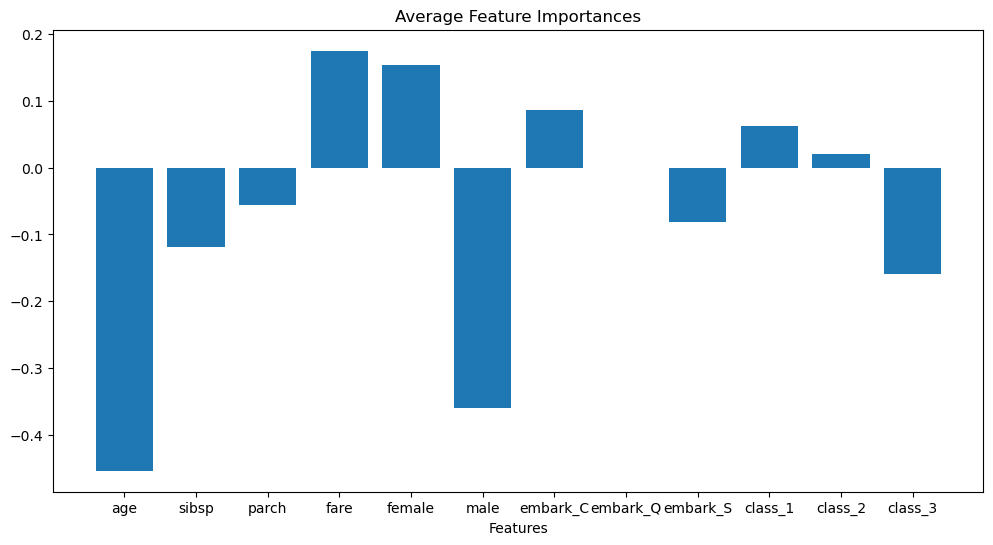

In [23]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

From the feature attribution information, we obtain some interesting insights regarding the importance of various features. We see that the strongest features appear to be age and being male, which are negatively correlated with survival. Embarking at Queenstown and the number of parents / children appear to be less important features generally.

An important thing to note is that the average attributions over the test set don't necessarilly capture all the information regarding feature importances. We should also look at the distribution of attributions for each feature. It is possible that features have very different attributions for different examples in the dataset. 

For instance, we can visualize the distribution of attributions for sibsp, the number of siblings / spouses.

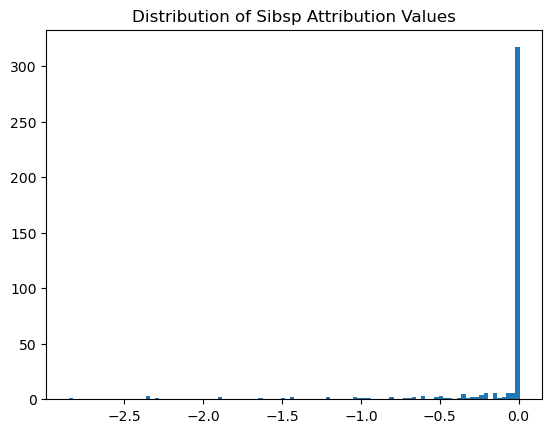

In [25]:
plt.hist(attr[:,1], 100);
plt.title("Distribution of Sibsp Attribution Values");

We note that a vast majority of the examples have an attribution value of 0 for sibsp, which likely corresponds to having a value of 0 for the feature (IntegratedGradients would provide an attribution of 0 when the feature value matches the baseline of 0). More significantly, we see that although the average seems smaller in magnitude in the plot above, there are a small number of examples with extremely negative attributions for this feature.

To better understand this, we can bucket the examples by the value of the sibsp feature and plot the average attribution for the feature. In the plot below, the size of the dot is proportional to the number of examples with that value.

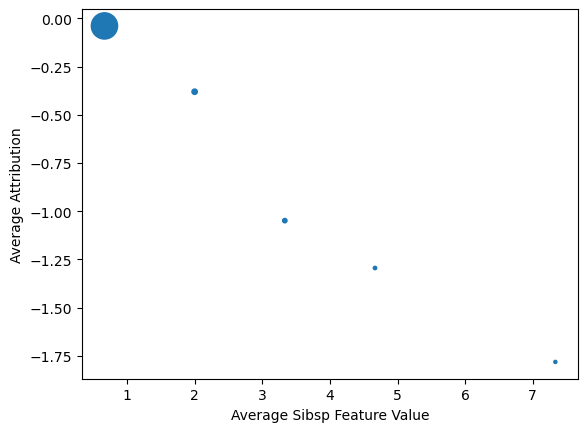

In [27]:
bin_means, bin_edges, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='mean', bins=6)
bin_count, _, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='count', bins=6)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.scatter(bin_centers, bin_means, s=bin_count)
plt.xlabel("Average Sibsp Feature Value");
plt.ylabel("Average Attribution");


We see that the larger magnitude attributions correspond to the examples with larger Sibsp feature values, suggesting that the feature has a larger impact on prediction for these examples. Since there are substantially fewer of these examples (compared to those with a feature value of 0), the average attribution does not completely capture this effect.

Now that we have a better understanding of the importance of different input features, the next question we can ask regarding the function of the neural network is how the different neurons in each layer work together to reach the prediction. For instance, in our first hidden layer output containing 12 units, are all the units used for prediction? Do some units learn features positively correlated with survival while others learn features negatively correlated with survival?

This leads us to the second type of attributions available in Captum, **Layer Attributions**. Layer attributions allow us to understand the importance of all the neurons in the output of a particular layer. For this example, we will be using Layer Conductance, one of the Layer Attribution methods in Captum, which is an extension of Integrated Gradients applied to hidden neurons. More information regarding conductance can be found in the original paper here: https://arxiv.org/abs/1805.12233.

To use Layer Conductance, we create a LayerConductance object passing in the model as well as the module (layer) whose output we would like to understand. In this case, we choose net.sigmoid1, the output of the first hidden layer.

In [29]:
cond = LayerConductance(net, net.sigmoid1)

We can now obtain the conductance values for all the test examples by calling attribute on the LayerConductance object. LayerConductance also requires a target index for networks with mutliple outputs, defining the index of the output for which gradients are computed. Similar to feature attributions, we provide target=1, corresponding to survival. LayerConductance also utilizes a baseline, but we simply use the default zero baseline as in Integrated Gradients.

In [31]:
cond_vals = cond.attribute(test_input_tensor,target=1)
cond_vals = cond_vals.detach().numpy()

We can begin by visualizing the average conductance for each neuron.

Average Neuron Importances
0 :  -0.123
1 :  -0.040
2 :  0.030
3 :  0.012
4 :  -0.022
5 :  -0.137
6 :  0.009
7 :  0.001
8 :  -0.136
9 :  -0.000
10 :  -0.306
11 :  0.016


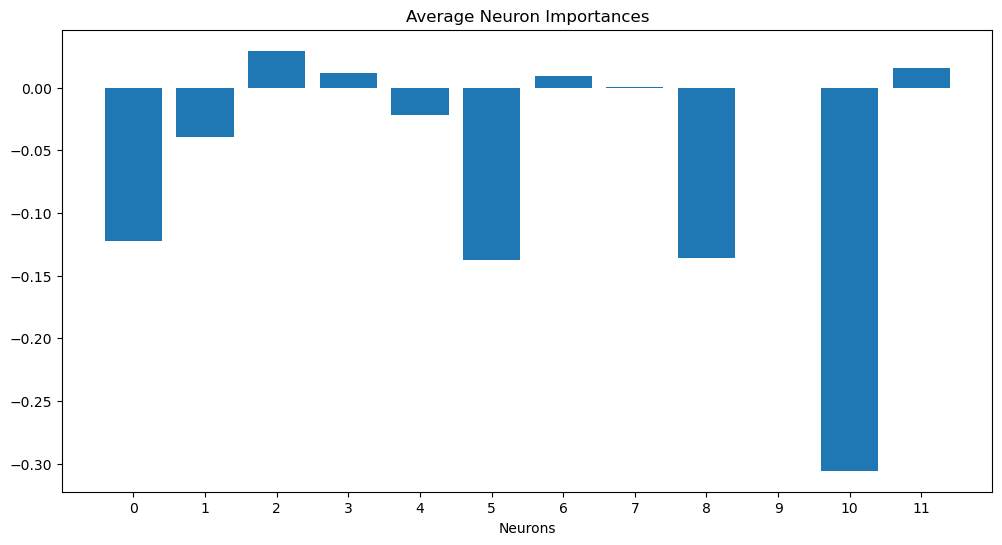

In [33]:
visualize_importances(range(12),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")

We can also look at the distribution of each neuron's attributions. Below we look at the distributions for neurons 7 and 9, and we can confirm that their attribution distributions are very close to 0, suggesting they are not learning substantial features.

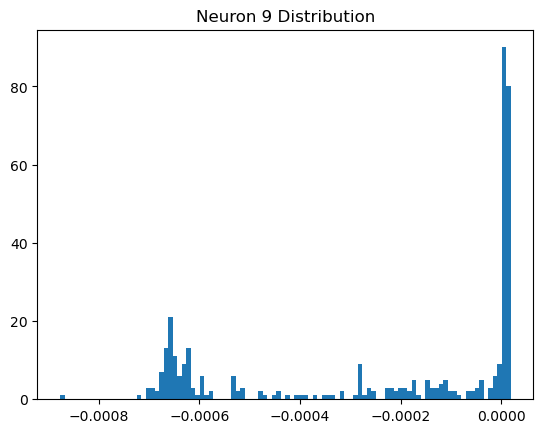

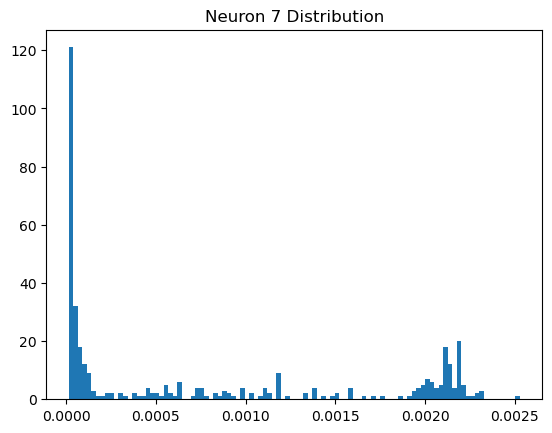

In [35]:
plt.hist(cond_vals[:,9], 100);
plt.title("Neuron 9 Distribution")
plt.figure()
plt.hist(cond_vals[:,7], 100);
plt.title("Neuron 7 Distribution");


Now, we can look at the distributions of neurons 0 and 10, which appear to be learning strong features negatively correlated with survival.

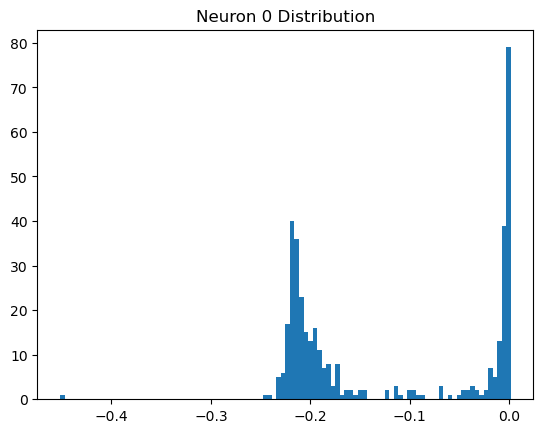

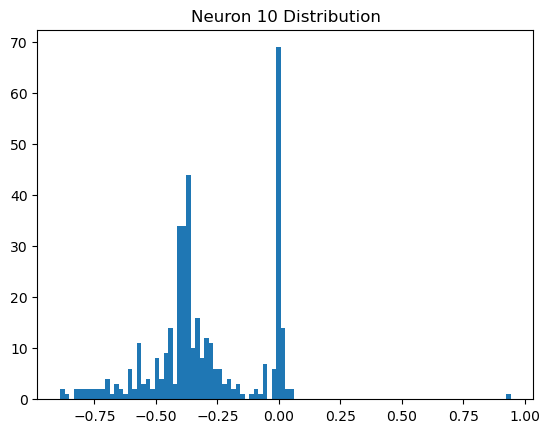

In [37]:
plt.hist(cond_vals[:,0], 100);
plt.title("Neuron 0 Distribution")
plt.figure()
plt.hist(cond_vals[:,10], 100);
plt.title("Neuron 10 Distribution");

We have identified that some of the neurons are not learning important features, while others are. Can we now understand what each of these important neurons are looking at in the input? For instance, are they identifying different features in the input or similar ones?

To answer these questions, we can apply the third type of attributions available in Captum, **Neuron Attributions**. This allows us to understand what parts of the input contribute to activating a particular input neuron. For this example, we will apply Neuron Conductance, which divides the neuron's total conductance value into the contribution from each individual input feature.

To use Neuron Conductance, we create a NeuronConductance object, analogously to Conductance, passing in the model as well as the module (layer) whose output we would like to understand, in this case, net.sigmoid1, as before.

In [39]:
neuron_cond = NeuronConductance(net, net.sigmoid1)

We can now obtain the neuron conductance values for all the test examples by calling attribute on the NeuronConductance object. Neuron Conductance requires the neuron index in the target layer for which attributions are requested as well as the target index for networks with mutliple outputs, similar to layer conductance. As before, we provide target=1, corresponding to survival, and compute neuron conductance for neurons 0 and 10, the significant neurons identified above. The neuron index can be provided either as a tuple or as just an integer if the layer output is 1-dimensional.

In [41]:
neuron_cond_vals_10 = neuron_cond.attribute(test_input_tensor, neuron_selector=10, target=1)

In [43]:
neuron_cond_vals_0 = neuron_cond.attribute(test_input_tensor, neuron_selector=0, target=1)

Average Feature Importances for Neuron 0
age :  -0.128
sibsp :  -0.004
parch :  0.003
fare :  0.003
female :  0.000
male :  0.001
embark_C :  0.006
embark_Q :  -0.000
embark_S :  -0.004
class_1 :  0.002
class_2 :  0.007
class_3 :  -0.019


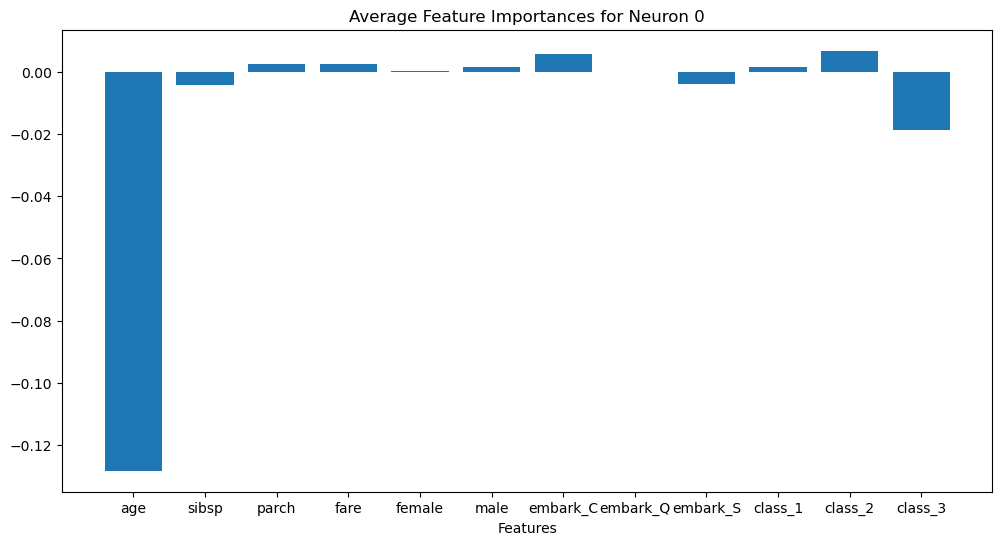

In [44]:
visualize_importances(feature_names, neuron_cond_vals_0.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 0")

From the data above, it appears that the primary input feature used by neuron 0 is age, with limited importance for all other features.

Average Feature Importances for Neuron 10
age :  -0.012
sibsp :  0.003
parch :  0.000
fare :  -0.015
female :  0.055
male :  -0.210
embark_C :  0.016
embark_Q :  -0.006
embark_S :  -0.052
class_1 :  0.022
class_2 :  0.009
class_3 :  -0.116


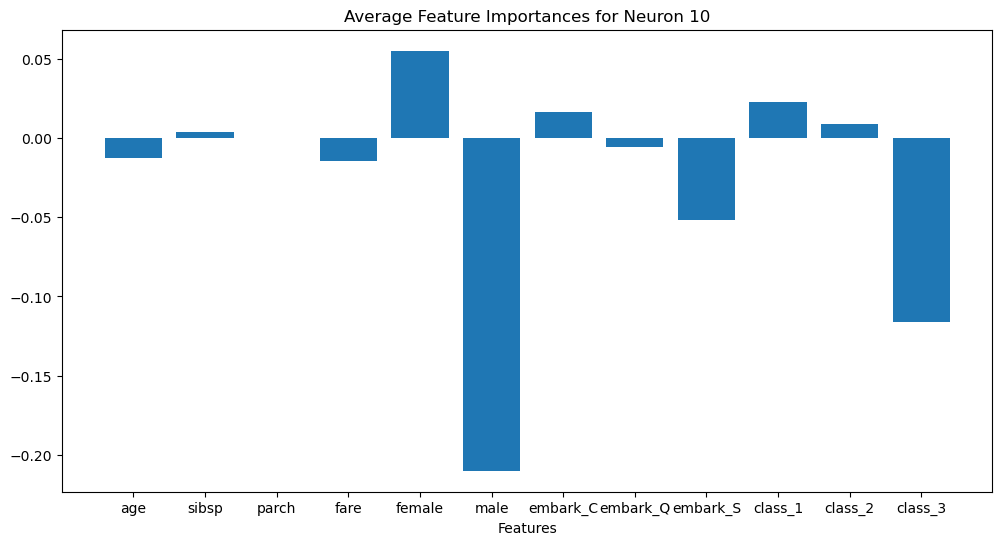

In [47]:
visualize_importances(feature_names, neuron_cond_vals_10.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 10")

From the visualization above, it is evident that neuron 10 primarily relies on the gender and class features, substantially different from the focus of neuron 0.

## Summary

In this demo, we have applied different attribution techniques in Captum including Integrated Gradients for feature attribution and Conductance for layer and neuron attribution in order to better understand the neural network predicting survival. Although larger networks are more difficult to analyze than this simple network, these basic building blocks for attribution can be utilized to improve model interpretability, breaking the traditional "black-box" characterization of neural networks and delving deeper into understanding how and why they make their decisions. 